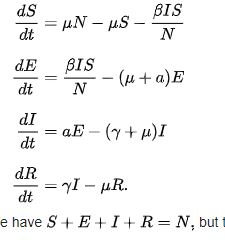

# Setup

0.4 0.2 0.2 180


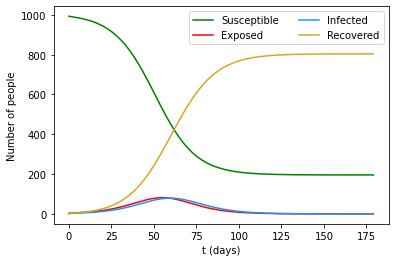

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math 
import requests 
import json
import pandas as pd
import matplotlib.dates as mdates
from datetime import date
from scipy import integrate, optimize

def model(beta,a,y,days):

  print(beta,a,y,days)

  #Set up parameters

  #N = 1000 total population
  #Initial infected = 5 so

  N = 1000
  S_0 = 995
  I_0 = 5

  S = S_0
  I = I_0
  I_cumulative = I_0

  # and R and E start at 0

  R = 0
  E = 0

 #create arrays for S, E, I and R


  S_arr = np.zeros(days)
  S_arr[0] = S
  #x = len(S_arr)
  #print(x)

  E_arr = np.zeros(days)
  E_arr[0] = E

  I_arr = np.zeros(days)
  I_arr[0] = I

  R_arr = np.zeros(days)
  R_arr[0] = R

  I_cum_arr = np.zeros(days)
  I_cum_arr[0] = I


  for x in range(days):

    S_1 = S - ((beta*S*I)/(N))
    E_1 = E + ((beta*S*I)/(N))-(a*E)
    R_1 = y*I + R
    I_1 = I + (a*E)-(y*I)

    #for cumulative infection, need to use instantaneous infection at time point

    I_cumulative = I_cumulative + (beta*S*I)/(N)

    S_arr[x] = S_1
    S = S_1

    E_arr[x] = E_1
    E = E_1

    I_arr[x] = I_1
    I = I_1

    R_arr[x] = R_1
    R = R_1

    I_cum_arr[x] = I_cumulative

  output = {'S':S_arr,'E':E_arr,'I':I_arr,'R':R_arr,'I_cum':I_cum_arr}
  return output


# Set up parameters and run 

#average 2 contacts per day each contact 20% likely to transmit

beta = 2*0.2

#  latency period is a random variable with exponential distribution with parameter a (i.e. the average latency period is a^-1)

a = 1/5

# R = yI If recovery takes 5 days then

y = 1/5


output = model(beta,a,y,180)

plt.plot(output.get("S"), c = 'green')
plt.plot(output.get("E"), c = 'red')
plt.plot(output.get("I"), c = 'dodgerblue')
plt.plot(output.get("R"), c = 'goldenrod')


plt.xlabel("t (days)")
plt.ylabel("Number of people")

#plt.legend(["Susceptible", "Exposed", "Infected","Recovered","Cumulative Infection"], ncol=2)
plt.legend(["Susceptible", "Exposed", "Infected","Recovered"], ncol=2)

plt.show()



# Training data

200
           Date  Cases
1175 2020-01-30      1
1174 2020-01-31      0
1173 2020-02-01      0
1172 2020-02-02      1
1171 2020-02-03     18
1170 2020-02-04      0
1169 2020-02-05      1
1168 2020-02-06      0
1167 2020-02-07      0
1166 2020-02-08      3
           Date  Cases
1144 2020-03-01     18
1143 2020-03-02     40
1142 2020-03-03     53
1141 2020-03-04     49
1140 2020-03-05     46
1139 2020-03-06     74
1138 2020-03-07     55
1137 2020-03-08     50
1136 2020-03-09    127
1135 2020-03-10    229


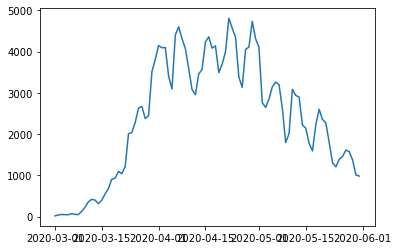

In [5]:
#move onto training parameters

# first to get data from COVID dashboard

response = requests.get("https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=E92000001&metric=newCasesBySpecimenDate&format=json",timeout=10)
print(response.status_code)

#print(response.json())

value_date = []
value_cases = []

for entry in response.json()['body']:
    value_date.append(entry['date'])
    value_cases.append(entry['newCasesBySpecimenDate'])

values_df = pd.DataFrame({'Date':value_date,
                           'Cases':value_cases})

values_df['Date'] = pd.to_datetime(values_df['Date'])

#print(values_df.info()) 

#print(values_df.head(10))

values_df.sort_values(by='Date', inplace=True)

print(values_df.head(10))

values_df = values_df[(values_df['Date']>='2020-03-01')&(values_df['Date']<='2020-05-31')]

print(values_df.head(10))

plt.plot(values_df.Date,values_df.Cases)

# Gridsearch

In [ ]:
# onto the gridsearch bit for parameters beta, a, y

#average 2 contacts per day each contact 20% likely to transmit
#beta = 2*0.2

#  latency period is a random variable with exponential distribution with parameter a (i.e. the average latency period is a^-1)
#a = 1/5

# R = yI If recovery takes 5 days then
#y = 1/5

import sklearn
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 
from scipy import integrate, optimize

#build a version of the model for training - set number of days and only return the people moving E to I (i.e a*E)

def fit_model(beta,a,y):

  print(beta,a,y)

  #Set up parameters

  #N = 1000 total population
  #Initial infected = 5 so

  N = 1000
  S_0 = 995
  I_0 = 5

  S = S_0
  I = I_0
  I_cumulative = I_0

  # and R and E start at 0

  R = 0
  E = 0

  days = 90

 #create arrays for S, E, I, R and cases


  S_arr = np.zeros(days)
  S_arr[0] = S
  #x = len(S_arr)
  #print(x)

  E_arr = np.zeros(days)
  E_arr[0] = E

  I_arr = np.zeros(days)
  I_arr[0] = I

  R_arr = np.zeros(days)
  R_arr[0] = R

  I_cum_arr = np.zeros(days)
  I_cum_arr[0] = I
  
  cases_arr = np.zeros(days)
  cases_arr[0] = I

  for x in range(days):

    S_1 = S - ((beta*S*I)/(N))
    E_1 = E + ((beta*S*I)/(N))-(a*E)
    R_1 = y*I + R
    I_1 = I + (a*E)-(y*I)
    cases_arr[x] = (a*E)


    S = S_1
    E = E_1
    I = I_1
    R = R_1

  output = {'row_num':x,'Cases':cases_arr}
  return output

#now use it to tune parameters

# ah - need to generate an id number on the training data

values_df['row_num'] = values_df.reset_index().index

param_grid = {'beta': [0.2, 0.4, 0.6],  
              'a': [0.1, 0.2, 0.3], 
              'y': [0.1, 0.2, 0.3]}  

seir_fit = sklearn.model_selection.GridSearchCV(fit_model, param_grid=param_grid, scoring='accuracy', refit=True, cv=5, verbose=1)
seir_fit.fit(values_df.row_num,values_df.Cases)
seir_fit.best_params_

# Example from online

[1.06700247 1.00874609]


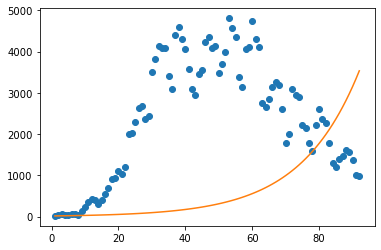

In [8]:
## EXAMPLE copied from online - going to try and tweak it to match above 

from scipy import integrate, optimize

#ydata = ['1e-06', '1.49920166169172e-06', '2.24595472686361e-06', '3.36377954575331e-06', '5.03793663882291e-06', '7.54533628058909e-06', '1.13006564683911e-05', '1.69249500601052e-05', '2.53483161761933e-05', '3.79636391699325e-05', '5.68567547875179e-05', '8.51509649182741e-05', '0.000127522555808945', '0.000189928392105942', '0.000283447055673738', '0.000423064043409294', '0.000631295993246634', '0.000941024110897193', '0.00140281896645859', '0.00209085569326554', '0.00311449589149717', '0.00463557784224762', '0.00689146863803467', '0.010227347567051', '0.0151380084180746', '0.0223233100045688', '0.0327384810150231', '0.0476330618585758', '0.0685260046667727', '0.0970432959143974', '0.134525888779423', '0.181363340075877', '0.236189247803334', '0.295374180276257', '0.353377036130714', '0.404138746080267', '0.442876028839178', '0.467273954573897', '0.477529937494976', '0.475582401936257', '0.464137179474659', '0.445930281787152', '0.423331710456602', '0.39821360956389', '0.371967226561944', '0.345577884704341', '0.319716449520481', '0.294819942458255', '0.271156813453547', '0.24887641905719', '0.228045466022105', '0.208674420183194', '0.190736203926912', '0.174179448652951', '0.158937806544529', '0.144936441326754', '0.132096533873646', '0.120338367115739', '0.10958340819268', '0.099755679236243', '0.0907826241267504', '0.0825956203546979', '0.0751302384111894', '0.0683263295744258', '0.0621279977639921', '0.0564834809370572', '0.0513449852139111', '0.0466684871328814', '0.042413516167789', '0.0385429293775096', '0.035022685071934', '0.0318216204865132', '0.0289112368382048', '0.0262654939162707', '0.0238606155312519', '0.021674906523588', '0.0196885815912485', '0.0178836058829335', '0.0162435470852779', '0.0147534385851646', '0.0133996531928511', '0.0121697868544064', '0.0110525517526551', '0.0100376781867076', '0.00911582462544914', '0.00827849534575178', '0.00751796508841916', '0.00682721019158058', '0.00619984569061827', '0.00563006790443123', '0.00511260205894446', '0.00464265452957236', '0.00421586931435123', '0.00382828837833139', '0.00347631553734708', '0.00315668357532714', '0.00286642431380459', '0.00260284137520731', '0.00236348540287827', '0.00214613152062159', '0.00194875883295343']
#xdata = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101']

ydata = values_df.Cases
ydata = np.array(ydata, dtype=float)

xdata = np.empty(len(ydata),int)

for i in range(len(xdata)):

    xdata[i] = i+1

# These are the equations from above (to cross-check against the online example)

# S_1 = S - ((beta*S*I)/(N))
# E_1 = E + ((beta*S*I)/(N))-(a*E)
# R_1 = y*I + R
# I_1 = I + (a*E)-(y*I)

# in the model below they use S, I, R to refer to dS/dt etc. 

def sir_model(y, x, beta, gamma):
    S = (-beta * y[0] * y[1] )/ N
    R = gamma * y[1]
    I = -(S + R)
    return S, I, R

def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (S0, I0, R0), x, args=(beta, gamma))[:,1]

N = 56000000.0  # this is population so I guess needs to be England pop
I0 = ydata[0]
S0 = N - I0
R0 = 0.0

beta = 0.2
gamma = 0.2

popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
print(popt)
fitted = fit_odeint(xdata, *popt)

plt.plot(xdata, ydata, 'o')
plt.plot(xdata, fitted)
plt.show()

In [7]:
from re import X
#d0 = date(2000, 1, 01)
#d1 = date.today()
#delta = d1 - d0
#print delta.days
xdata = values_df.Date 
ydata = values_df.Cases

#print (xdata)

print(len(xdata))

days = np.empty(len(xdata),int)

for x in range(len(xdata)):

    days[x] = x+1

print(days)

#print(xdata.iloc[[0]])
#print(days[0])
#print(ydata.iloc[[0]])

92
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92]



# Standalone test of fit model

In [ ]:
#standalone test of fit model to make sure it works first

def fit_model(beta,a,y):

  print(beta,a,y)

  #Set up parameters

  #N = 1000 total population
  #Initial infected = 5 so

  N = 1000
  S_0 = 995
  I_0 = 5

  S = S_0
  I = I_0
  I_cumulative = I_0

  # and R and E start at 0

  R = 0
  E = 0

  days = 90

 #create arrays for S, E, I, R and cases


  S_arr = np.zeros(days)
  S_arr[0] = S
  #x = len(S_arr)
  #print(x)

  E_arr = np.zeros(days)
  E_arr[0] = E

  I_arr = np.zeros(days)
  I_arr[0] = I

  R_arr = np.zeros(days)
  R_arr[0] = R

  I_cum_arr = np.zeros(days)
  I_cum_arr[0] = I
  
  cases_arr = np.zeros(days)
  cases_arr[0] = I

  for x in range(days):

    S_1 = S - ((beta*S*I)/(N))
    E_1 = E + ((beta*S*I)/(N))-(a*E)
    R_1 = y*I + R
    I_1 = I + (a*E)-(y*I)
    cases_arr[x] = (a*E)


    S = S_1
    E = E_1
    I = I_1
    R = R_1

  output = {'row_num':x,'Cases':cases_arr}
  return output

###

output = fit_model(0.4,0.2,0.2)

plt.plot(output.get("Cases"), c = 'green')

plt.xlabel("t (days)")
plt.ylabel("Number of people")


plt.show()

In [ ]:
sorted(sklearn.metrics.SCORERS.keys())